# Data Integration & Text Embeddings with PCA Analysis

**Objective**: Load multi-source data, merge on product names, generate text embeddings, and perform PCA analysis with automatic variance threshold optimization.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.graph_objs as go
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sentence_transformers import SentenceTransformer
from skrub import TableReport
from skrub import Cleaner
import warnings
warnings.filterwarnings('ignore')

/home/francois/anaconda3/envs/dl/lib/python3.12/site-packages/requests/__init__.py:86: RequestsDependencyWarning: Unable to find acceptable character detection dependency (chardet or charset_normalizer).
  warnings.warn(


## 1. Load and Merge Data Sources

In [2]:
# ===== CONFIGURATION =====
DATA_FILE_1 = "Donnees_IA_2025.xlsx"
DATA_FILE_2 = "feedtables_definitions_formatted.xlsx"
SHEET_NAME_2 = "Données Nutritionnelles"
VARIANCE_THRESHOLD = 0.95
N_COMPONENTS_3D = 3

# ===== DEFINE COLUMNS =====
vars_expl = [
    "MS % brut", "PB % brut", "CB % brut", "MGR % brut", "MM % brut",
    "NDF % brut", "ADF % brut", "Lignine % brut", "Amidon % brut", "Sucres % brut"
]

vars_cibles = [
    "EB (kcal) kcal/kg brut", "ED porc croissance (kcal) kcal/kg brut", "EM porc croissance (kcal) kcal/kg brut",
    "EN porc croissance (kcal) kcal/kg brut", "EMAn coq (kcal) kcal/kg brut", "EMAn poulet (kcal) kcal/kg brut",
    "UFL 2018 par kg brut", "UFV 2018 par kg brut", "PDIA 2018 g/kg brut", "PDI 2018 g/kg brut", "BalProRu 2018 g/kg brut"
]

cols_to_keep = ["Nom"] + vars_expl + vars_cibles

# ===== LOAD DATA =====
df_data_ia = pd.read_excel(DATA_FILE_1)
df_feedtables = pd.read_excel(DATA_FILE_2, sheet_name=SHEET_NAME_2)

# ===== FIX COLUMN NAMES (underscores to slashes) =====
# The feedtables file uses underscores instead of slashes in column names
df_feedtables = df_feedtables.rename(columns={
    'PDIA 2018 g_kg brut': 'PDIA 2018 g/kg brut',
    'PDI 2018 g_kg brut': 'PDI 2018 g/kg brut',
    'BalProRu 2018 g_kg brut': 'BalProRu 2018 g/kg brut'
})

# ===== CLEAN DATA =====
cleaner = Cleaner()
df_data_ia = cleaner.fit_transform(df_data_ia)
df_feedtables = cleaner.fit_transform(df_feedtables)
cleaner.all_processing_steps_

# Remove Classe : "Minéraux" column from Feedtables
df_feedtables = df_feedtables[df_feedtables["Classe"] != "Minéraux"]

# Keep only relevant columns for IA data
df_data_ia = df_data_ia[cols_to_keep].drop_duplicates()

# For Feedtables, keep all vars_expl + vars_cibles + Nom + Definition
cols_feedtables_target = ["Nom"] + vars_expl + vars_cibles + ["Definition"]
# Create new dataframe with all target columns, filling missing ones with NaN
df_feedtables_new = pd.DataFrame()
for col in cols_feedtables_target:
    if col in df_feedtables.columns:
        df_feedtables_new[col] = df_feedtables[col]
    else:
        df_feedtables_new[col] = np.nan

# Fill 'Nom' from original feedtables if not already present
if "Nom" not in df_feedtables_new.columns or df_feedtables_new["Nom"].isna().all():
    if "Nom" in df_feedtables.columns:
        df_feedtables_new["Nom"] = df_feedtables["Nom"]

df_feedtables = df_feedtables_new.drop_duplicates()

# Rename Nom from feedtables to avoid conflict during join
df_feedtables = df_feedtables.rename(columns={"Nom": "Nom_feedtables"})

print(f"✓ Données_IA: {len(df_data_ia)} products")
print(f"✓ Feedtables: {len(df_feedtables)} products")


✓ Données_IA: 6352 products
✓ Feedtables: 222 products


In [3]:
report = TableReport(df_data_ia)
report

Processing column  22 / 22


<TableReport: use .open() to display>

In [4]:
report = TableReport(df_feedtables)
report

Processing column  23 / 23


<TableReport: use .open() to display>

## 1.1 Fuzzy Join: Merge Data Sources

In [5]:
# ===== FUZZY JOIN ON NOM =====
import skrub

print("\n🔗 Performing fuzzy join to identify matching names...\n")

# Create a mapping of Feedtables names to IA names using fuzzy join
fuzzy_match_df = skrub.fuzzy_join(
    df_data_ia[['Nom']].drop_duplicates(),
    df_feedtables[['Nom_feedtables']].drop_duplicates(),
    left_on='Nom',
    right_on='Nom_feedtables',
    add_match_info=True
)

# Extract match information
distance_col = [col for col in fuzzy_match_df.columns if 'Joiner_distance' in col][0]

# Add source and OOD columns to each dataset
df_data_ia_tagged = df_data_ia.copy()
df_data_ia_tagged['source'] = 'Donnees_IA'
df_data_ia_tagged['OOD'] = 0
df_data_ia_tagged['match_distance'] = 0.0  # IA products are considered perfect self-matches

# Create Definition mapping from Feedtables for enrichment
definition_mapping = df_feedtables[["Nom_feedtables", "Definition"]].drop_duplicates()
definition_mapping = definition_mapping[definition_mapping['Nom_feedtables'].notna() & definition_mapping['Definition'].notna()]
definition_map = dict(zip(definition_mapping['Nom_feedtables'], definition_mapping['Definition']))

# Enrich IA definitions from Feedtables using fuzzy join mapping
df_data_ia_tagged['Definition'] = df_data_ia_tagged['Nom'].apply(
    lambda x: definition_map.get(fuzzy_match_df[fuzzy_match_df['Nom'] == x]['Nom_feedtables'].iloc[0], np.nan)
    if not fuzzy_match_df[fuzzy_match_df['Nom'] == x].empty else np.nan
)

df_feedtables_tagged = df_feedtables.copy()
# Restore the original 'Nom' column name for Feedtables
df_feedtables_tagged = df_feedtables_tagged.rename(columns={"Nom_feedtables": "Nom"})
df_feedtables_tagged['source'] = 'Feedtable'
df_feedtables_tagged['OOD'] = 1  # All Feedtables are out-of-distribution (separate samples)
# Add match distance info for Feedtables based on fuzzy join
match_dict = dict(zip(fuzzy_match_df['Nom_feedtables'].dropna(), fuzzy_match_df[distance_col]))
df_feedtables_tagged['match_distance'] = df_feedtables_tagged['Nom'].map(match_dict).fillna(np.nan)

# Concatenate both datasets
df_merged = pd.concat([df_data_ia_tagged, df_feedtables_tagged], ignore_index=True)

print(f"✓ Merged: {len(df_merged)} products")
print(f"  - Donnees_IA: {len(df_data_ia_tagged)} products")
print(f"  - Feedtables: {len(df_feedtables_tagged)} products")

# ===== ANALYZE MATCH QUALITY FOR FEEDTABLES =====
print(f"\n📊 Feedtables matching with IA names:")
matched_count = df_feedtables_tagged['match_distance'].notna().sum()
perfect_count = (df_feedtables_tagged['match_distance'] == 0.0).sum()
good_count = ((df_feedtables_tagged['match_distance'] > 0) & (df_feedtables_tagged['match_distance'] < 0.2)).sum()
fuzzy_count = (df_feedtables_tagged['match_distance'] >= 0.2).sum()

print(f"  - Feedtables WITH match: {matched_count}")
print(f"    • Perfect matches (distance=0): {perfect_count}")
print(f"    • Good matches (0 < distance<0.2): {good_count}")
print(f"    • Fuzzy matches (distance≥0.2): {fuzzy_count}")
print(f"  - Feedtables WITHOUT match: {len(df_feedtables_tagged) - matched_count}")

# Show fuzzy matches details (only non-perfect matches)
fuzzy_feedtables = df_feedtables_tagged[
    (df_feedtables_tagged['match_distance'] > 0) & (df_feedtables_tagged['match_distance'].notna())
][['Nom', 'match_distance']].drop_duplicates().sort_values(by='match_distance')

if len(fuzzy_feedtables) > 0:
    print(f"\n🔍 Fuzzy matches details ({len(fuzzy_feedtables)} items):")
    
    def color_dist(val):
        if val < 0.2:
            return 'background-color: #c8e6c9'  # Green
        elif val < 0.4:
            return 'background-color: #fff9c4'  # Yellow
        else:
            return 'background-color: #ffcdd2'  # Red
    
    display(fuzzy_feedtables.style.applymap(color_dist, subset=['match_distance']).format({'match_distance': "{:.4f}"}))

print(f"\n📋 Data source breakdown:")
print(df_merged['source'].value_counts())
print(f"\n📊 OOD breakdown:")
print(f"  - In Distribution (OOD=0): {(df_merged['OOD'] == 0).sum()}")
print(f"  - Out Of Distribution (OOD=1): {(df_merged['OOD'] == 1).sum()}")



🔗 Performing fuzzy join to identify matching names...

✓ Merged: 6574 products
  - Donnees_IA: 6352 products
  - Feedtables: 222 products

📊 Feedtables matching with IA names:
  - Feedtables WITH match: 70
    • Perfect matches (distance=0): 40
    • Good matches (0 < distance<0.2): 0
    • Fuzzy matches (distance≥0.2): 30
  - Feedtables WITHOUT match: 152

🔍 Fuzzy matches details (30 items):



📋 Data source breakdown:
source
Donnees_IA    6352
Feedtable      222
Name: count, dtype: int64

📊 OOD breakdown:
  - In Distribution (OOD=0): 6352
  - Out Of Distribution (OOD=1): 222


In [6]:
# ===== FEEDTABLES MATCHING WITH IA NAMES =====
print("\n📊 Feedtables matching with IA names:")

# Products WITH match
feedtables_with_match = df_merged[(df_merged['source'] == 'Feedtable') & (df_merged['match_distance'].notna())]
print(f"  ✓ WITH match: {feedtables_with_match['Nom'].nunique()} products")
print(f"    {', '.join(feedtables_with_match['Nom'].drop_duplicates().head(10).tolist())}")

# Products WITHOUT match
feedtables_without_match = df_merged[(df_merged['source'] == 'Feedtable') & (df_merged['match_distance'].isna())]
print(f"\n  ✗ WITHOUT match: {feedtables_without_match['Nom'].nunique()} products")


📊 Feedtables matching with IA names:
  ✓ WITH match: 70 products
    Amidon de maïs, Avoine, Balle de riz, Blé tendre, Concentré protéique de luzerne, Concentré protéique de pois, Coproduits de biscuiterie, Coques de soja, Corn gluten feed, Corn gluten meal

  ✗ WITHOUT match: 152 products


In [7]:
report = TableReport(df_merged)
report

Processing column  26 / 26


<TableReport: use .open() to display>

## 2. Prepare Data for Embeddings

In [8]:
# Create combined text feature for embeddings
df_merged['text_combined'] = df_merged['Nom'].astype(str) + "; " + df_merged['Definition'].astype(str)

print(f"\n✓ Data prepared for embeddings")
print(f"  - Products with definition: {(df_merged['Definition'].str.len() > 0).sum()}")
print(f"  - Products without definition: {(df_merged['Definition'].str.len() == 0).sum()}")


✓ Data prepared for embeddings
  - Products with definition: 6574
  - Products without definition: 0


## 3. Generate Text Embeddings

In [9]:
# ===== OPTIMIZED EMBEDDING GENERATION (UNIQUE TEXTS ONLY) =====
from sentence_transformers import SentenceTransformer
import numpy as np

EMBEDDING_MODEL = "dangvantuan/sentence-camembert-base"

print("Generating embeddings for unique texts only...")
print(f"  - Loading model: {EMBEDDING_MODEL}")

# Get unique texts and their indices
unique_texts_series = df_merged['text_combined'].drop_duplicates().reset_index(drop=True)
unique_texts_list = unique_texts_series.tolist()

print(f"  - Unique texts to embed: {len(unique_texts_list)}")

# Load model
model = SentenceTransformer(EMBEDDING_MODEL)

# Generate embeddings for unique texts only
embeddings_unique = model.encode(unique_texts_list, show_progress_bar=False, batch_size=32)

print(f"\n✓ Embeddings generated for unique texts")
print(f"  - Shape: {embeddings_unique.shape}")
print(f"  - Unique samples: {embeddings_unique.shape[0]}")
print(f"  - Dimensions: {embeddings_unique.shape[1]}")

# Save unique embeddings
np.save('embeddings_unique.npy', embeddings_unique)
print("✓ Unique embeddings saved to 'embeddings_unique.npy'")

Generating embeddings for unique texts only...
  - Loading model: dangvantuan/sentence-camembert-base
  - Unique texts to embed: 285

✓ Embeddings generated for unique texts
  - Shape: (285, 768)
  - Unique samples: 285
  - Dimensions: 768
✓ Unique embeddings saved to 'embeddings_unique.npy'


In [10]:
# ===== CREATE MAPPING: ALL PRODUCTS -> UNIQUE EMBEDDINGS =====

print("Creating embedding mapping for all products...")

# Create a mapping from text_combined to embedding index
text_to_idx = {text: idx for idx, text in enumerate(unique_texts_list)}

# Map all 6574 products to their unique embedding indices
embedding_indices = df_merged['text_combined'].map(text_to_idx).values

# Create the full embedding matrix by mapping
embeddings_all = embeddings_unique[embedding_indices]

print(f"\n✓ Mapping created")
print(f"  - Full embedding matrix: {embeddings_all.shape}")
print(f"  - All products: {embeddings_all.shape[0]}")
print(f"  - Dimensions: {embeddings_all.shape[1]}")

# Save full embeddings matrix
np.save('embeddings_combined.npy', embeddings_all)
print("✓ Full embeddings saved to 'embeddings_combined.npy'")

# Add embedding index to df_merged for reference
df_merged['embedding_idx'] = embedding_indices

Creating embedding mapping for all products...

✓ Mapping created
  - Full embedding matrix: (6574, 768)
  - All products: 6574
  - Dimensions: 768
✓ Full embeddings saved to 'embeddings_combined.npy'


## 4. PCA Dimensionality Reduction

In [11]:
print("Applying PCA...")

# Standardize embeddings
scaler = StandardScaler()
embeddings_scaled = scaler.fit_transform(embeddings_all)

# Fit PCA with all components to analyze variance
pca_full = PCA()
pca_full.fit(embeddings_scaled)

# Compute cumulative variance
cumsum_var = np.cumsum(pca_full.explained_variance_ratio_)

# Find n_components for variance threshold
n_components_threshold = np.argmax(cumsum_var >= VARIANCE_THRESHOLD) + 1

print(f"✓ Components for {VARIANCE_THRESHOLD*100:.0f}% variance: {n_components_threshold}")
print(f"✓ Variance explained: {cumsum_var[n_components_threshold-1]*100:.2f}%")

# Fit PCA with optimal number of components
pca_optimal = PCA(n_components=n_components_threshold)
embeddings_pca_optimal = pca_optimal.fit_transform(embeddings_scaled)

# Also fit 3D PCA for visualization
pca_3d = PCA(n_components=N_COMPONENTS_3D)
embeddings_pca_3d = pca_3d.fit_transform(embeddings_scaled)

print(f"✓ Embeddings PCA shape (optimal): {embeddings_pca_optimal.shape}")
print(f"✓ Embeddings PCA shape (3D viz): {embeddings_pca_3d.shape}")

Applying PCA...
✓ Components for 95% variance: 43
✓ Variance explained: 95.28%
✓ Embeddings PCA shape (optimal): (6574, 43)
✓ Embeddings PCA shape (3D viz): (6574, 3)


## 5. Variance Analysis & 3D Visualization

In [12]:
# ===== COMBINED VARIANCE + 3D VISUALIZATION =====
from plotly.subplots import make_subplots

# VARIANCE PLOT
fig_var = go.Figure()

# Individual variance
fig_var.add_trace(go.Scatter(
    x=list(range(1, min(51, len(pca_full.explained_variance_ratio_)+1))),
    y=pca_full.explained_variance_ratio_[:50],
    mode='lines+markers',
    name='Individual Variance',
    line=dict(color='#0072B2', width=2),
    marker=dict(size=4)
))

# Cumulative variance
fig_var.add_trace(go.Scatter(
    x=list(range(1, min(51, len(cumsum_var)+1))),
    y=cumsum_var[:50],
    mode='lines+markers',
    name='Cumulative Variance',
    line=dict(color='#D55E00', width=2, dash='dash'),
    marker=dict(size=4)
))

# Threshold line
fig_var.add_hline(y=VARIANCE_THRESHOLD, line_dash="dot", line_color="#CC0000", 
                  annotation_text=f'{VARIANCE_THRESHOLD*100:.0f}% Threshold', 
                  annotation_position="right")

# Optimal n_components line
fig_var.add_vline(x=n_components_threshold, line_dash="dashdot", line_color="#009E73",
                  annotation_text=f'n={n_components_threshold}', 
                  annotation_position="top")

fig_var.update_layout(
    title='PCA Variance Analysis',
    xaxis_title='Number of Components',
    yaxis_title='Explained Variance Ratio',
    template='plotly_white',
    height=500,
    hovermode='x unified'
)

# 3D PLOT (COLORED BY OOD vs IID)
colors = ['#1f77b4' if ood == 0 else '#ff4444' for ood in df_merged['OOD']]

fig_3d = go.Figure()

fig_3d.add_trace(go.Scatter3d(
    x=embeddings_pca_3d[:, 0],
    y=embeddings_pca_3d[:, 1],
    z=embeddings_pca_3d[:, 2],
    mode='markers',
    marker=dict(size=5, color=colors, opacity=0.75, line=dict(width=0.3, color='white')),
    text=df_merged['Nom'].tolist(),
    hovertemplate='%{text}<extra></extra>',
    showlegend=False
))

# Add legend
for name, color in zip(['IID (In-Distribution)', 'OOD (Out-Of-Distribution)'],
                       ['#1f77b4', '#ff4444']):
    fig_3d.add_trace(go.Scatter3d(x=[None], y=[None], z=[None], mode='markers',
                                   marker=dict(size=8, color=color), name=name))

fig_3d.update_layout(
    title=f'3D PCA Projection (Variance: {pca_3d.explained_variance_ratio_.sum()*100:.1f}%)',
    scene=dict(
        xaxis_title=f'PC1 ({pca_3d.explained_variance_ratio_[0]*100:.1f}%)',
        yaxis_title=f'PC2 ({pca_3d.explained_variance_ratio_[1]*100:.1f}%)',
        zaxis_title=f'PC3 ({pca_3d.explained_variance_ratio_[2]*100:.1f}%)',
    ),
    height=600, width=1000
)

fig_var.show()
fig_3d.show()

print(f"\n✓ PCA Analysis Complete")
print(f"  - Components for {VARIANCE_THRESHOLD*100:.0f}% variance: {n_components_threshold}")
print(f"  - Variance captured: {cumsum_var[n_components_threshold-1]*100:.2f}%")
print(f"  - Total samples: {embeddings_all.shape[0]}")
print(f"  - 3D variance explained: {pca_3d.explained_variance_ratio_.sum()*100:.1f}%")


✓ PCA Analysis Complete
  - Components for 95% variance: 43
  - Variance captured: 95.28%
  - Total samples: 6574
  - 3D variance explained: 28.1%


## Split des données en OOD/InD en utilisant la similarité des embedding de textes entre la table 1 et 2

[Split] nA=6352 nB=222 | name_col='Nom'

[OOD summary on Feedtable rows]
decision
OOD    146
ID      76
Name: count, dtype: int64
[Validate] Perfect fuzzy matches: 40 | violations (min_dist >= 0.044): 0
[Validate] Exact normalized name in A: 40 | violations (min_dist >= 0.044): 0


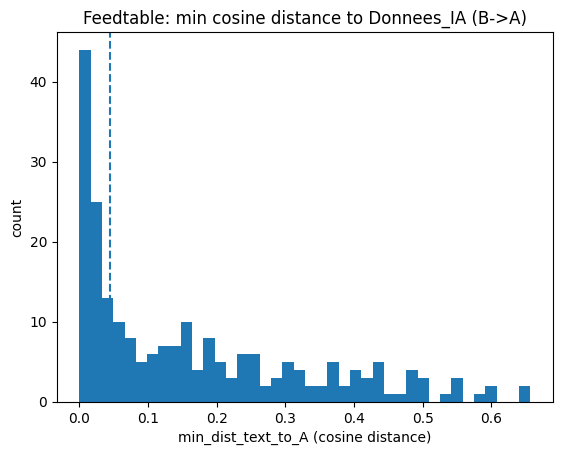

Processing column   6 / 6


<TableReport: use .open() to display>

In [13]:
# ============================
# OOD labeling (distance-only rule) for Feedtable rows (B)
# Runs AFTER embeddings are computed AND df_merged is built, BEFORE export
# Decision rule: min_dist_text_to_A < 0.044 => ID else OOD
# ============================

import numpy as np
from sklearn.neighbors import NearestNeighbors
import matplotlib.pyplot as plt
from skrub import TableReport
import re
import unicodedata

# ----------------------------
# 0) Inputs / column names (from your notebook)
# ----------------------------
df = df_merged.copy()

source_col = "source"
val_A = "Donnees_IA"
val_B = "Feedtable"

assert source_col in df.columns, f"Missing '{source_col}' in df_merged."
assert "Nom" in df.columns or "Nom_feedtables" in df.columns, "Need a name column ('Nom' or 'Nom_feedtables')."

name_col = "Nom" if "Nom" in df.columns else "Nom_feedtables"

mask_A = df[source_col].astype(str).eq(val_A)
mask_B = df[source_col].astype(str).eq(val_B)

print(f"[Split] nA={mask_A.sum()} nB={mask_B.sum()} | name_col='{name_col}'")

# ----------------------------
# 1) Load / select embedding matrix aligned with df
# ----------------------------
E = None
for cand in ["embeddings_combined", "embeddings_full", "embeddings"]:
    if cand in globals() and isinstance(globals()[cand], np.ndarray):
        E = globals()[cand]
        break
if E is None:
    E = np.load("embeddings_combined.npy")

E = np.asarray(E)
assert E.shape[0] == len(df), f"Embeddings rows ({E.shape[0]}) != df rows ({len(df)})."

# L2 normalize -> cosine distance stable
E_norm = E / (np.linalg.norm(E, axis=1, keepdims=True) + 1e-12)

# ----------------------------
# 2) B -> A nearest neighbor (cosine distance)
# ----------------------------
idx_A = np.where(mask_A.values)[0]
idx_B = np.where(mask_B.values)[0]

EA = E_norm[idx_A]
EB = E_norm[idx_B]

nn = NearestNeighbors(n_neighbors=1, metric="cosine", algorithm="auto").fit(EA)
dist_BA, nn_pos = nn.kneighbors(EB, return_distance=True)

min_dist = dist_BA.reshape(-1)               # min_dist_text_to_A (cosine distance)
best_A_global_idx = idx_A[nn_pos.reshape(-1)]
best_A_match = df.loc[best_A_global_idx, name_col].astype(str).to_numpy()

# ----------------------------
# 3) Distance-only decision rule
# ----------------------------
HARD_ID_DIST = 0.044

is_id = min_dist < HARD_ID_DIST
decision = np.where(is_id, "ID", "OOD")
ood = (~is_id).astype(int)

# simple confidence:
# - for ID: closer to 0 is higher confidence
# - for OOD: further above threshold is higher confidence
conf_id = np.clip(1.0 - (min_dist / HARD_ID_DIST), 0, 1)
conf_ood = np.clip((min_dist - HARD_ID_DIST) / (1.0 - HARD_ID_DIST), 0, 1)
confidence = np.where(is_id, conf_id, conf_ood)

# ----------------------------
# 4) Write results back into df_merged for Feedtable rows
# ----------------------------
for col in ["min_dist_text_to_A", "best_A_match", "decision", "confidence", "OOD", "ood_threshold"]:
    if col not in df.columns:
        df[col] = np.nan

df.loc[idx_B, "min_dist_text_to_A"] = min_dist
df.loc[idx_B, "best_A_match"] = best_A_match
df.loc[idx_B, "decision"] = decision
df.loc[idx_B, "confidence"] = confidence
df.loc[idx_B, "OOD"] = ood
df.loc[idx_B, "ood_threshold"] = HARD_ID_DIST

df_merged = df  # keep in notebook namespace

print("\n[OOD summary on Feedtable rows]")
print(df_merged.loc[idx_B, "decision"].value_counts())

# 6) Auto-validation of HARD_ID_DIST (sanity checks)

def _strip_accents(s: str) -> str:
    s = unicodedata.normalize("NFKD", s)
    return "".join(c for c in s if not unicodedata.combining(c))

def normalize_text(s: str) -> str:
    if s is None:
        return ""
    s = str(s).lower().strip()
    s = _strip_accents(s)
    s = re.sub(r"[/_,;:()\[\]{}]", " ", s)
    s = re.sub(r"\s+", " ", s).strip()
    return s

HARD_ID_DIST = float(HARD_ID_DIST)  # ensure float

mask_A = df_merged[source_col].astype(str).eq(val_A)
mask_B = df_merged[source_col].astype(str).eq(val_B)

# --- build exact-normalized name membership A ---
A_names_norm = set(df_merged.loc[mask_A, name_col].astype(str).map(normalize_text))
B_names_norm = df_merged.loc[mask_B, name_col].astype(str).map(normalize_text)

# indexes of B rows
idx_B = df_merged.index[mask_B]

# --- Check #1: perfect fuzzy matches (if match_distance exists) ---
if "match_distance" in df_merged.columns:
    perfect = mask_B & df_merged["match_distance"].notna() & (df_merged["match_distance"] == 0)
    n_perf = int(perfect.sum())
    if n_perf > 0:
        viol = df_merged.loc[perfect, "min_dist_text_to_A"] >= HARD_ID_DIST
        n_viol = int(viol.sum())
        print(f"[Validate] Perfect fuzzy matches: {n_perf} | violations (min_dist >= {HARD_ID_DIST}): {n_viol}")

        if n_viol > 0:
            display(
                df_merged.loc[perfect].loc[viol, [name_col, "best_A_match", "min_dist_text_to_A", "match_distance", "decision", "confidence"]]
                .sort_values("min_dist_text_to_A", ascending=False)
                .head(20)
            )
    else:
        print("[Validate] No perfect fuzzy matches found (match_distance==0).")
else:
    print("[Validate] match_distance column not found -> skip fuzzy-perfect sanity check.")

# --- Check #2: exact normalized name appears in A ---
exact_in_A = mask_B & B_names_norm.isin(A_names_norm)
n_exact = int(exact_in_A.sum())
if n_exact > 0:
    viol2 = df_merged.loc[exact_in_A, "min_dist_text_to_A"] >= HARD_ID_DIST
    n_viol2 = int(viol2.sum())
    print(f"[Validate] Exact normalized name in A: {n_exact} | violations (min_dist >= {HARD_ID_DIST}): {n_viol2}")

    if n_viol2 > 0:
        display(
            df_merged.loc[exact_in_A].loc[viol2, [name_col, "best_A_match", "min_dist_text_to_A", "decision", "confidence"]]
            .sort_values("min_dist_text_to_A", ascending=False)
            .head(20)
        )
else:
    print("[Validate] No B names exactly (normalized) found in A.")

# ----------------------------
# 5) Diagnostics + viz
# ----------------------------
plt.figure()
plt.hist(min_dist, bins=40)
plt.axvline(HARD_ID_DIST, linestyle="--")
plt.title("Feedtable: min cosine distance to Donnees_IA (B->A)")
plt.xlabel("min_dist_text_to_A (cosine distance)")
plt.ylabel("count")
plt.show()

# full decision table for debugging (all 222 rows)
viewB = df_merged.loc[idx_B, [name_col, "best_A_match", "min_dist_text_to_A", "decision", "confidence", "OOD"]].copy()
viewB = viewB.sort_values(["OOD", "min_dist_text_to_A"], ascending=[False, False])

report = TableReport(viewB)
report






In [16]:
# Visualiser la table de décision (robuste aux colonnes absentes)
cols_wanted = [
    "Nom",
    "best_A_match",
    "min_dist_text_to_A",
    "fuzzy_dist_to_A",
    "gap_top1_top2",
    "decision",
    "confidence",
    "OOD",
]

cols_available = [c for c in cols_wanted if c in df_merged.columns]

viewB = df_merged.loc[df_merged["source"] == "Feedtable", cols_available].copy()
viewB = viewB.sort_values(["OOD", "min_dist_text_to_A"], ascending=[False, False])

display(viewB.head(30))


Nom  \
6443                                         L-arginine   
6424                                  Herbe déshydratée   
6379                                      DL-méthionine   
6480                    Méthionine Hydroxy Analogue MHA   
6483                           Patate douce déshydratée   
6432                        Huile de poisson (menhaden)   
6435                         Huile de poisson (sébaste)   
6444                                       L-isoleucine   
6357                        Bananes vertes déshydratées   
6434                          Huile de poisson (saumon)   
6518                                           Saindoux   
6456                                          Lentilles   
6431                          Huile de poisson (hareng)   
6430                         Huile de poisson (capelan)   
6488                 Pomme de terre entière déshydratée   
6446                                        L-thréonine   
6448                                           L-valine   
6454  Larves de mouche soldat, matières grasses > 20...   
6453  Larves de mouche soldat, matières grasses < 20...   
6524                                    Son de moutarde   
6447                                      L-tryptophane   
6370                           Coproduit de boulangerie   
6569                         Vinasse d'acide glutamique   
6421                    Graisse de cuisson de volailles   
6427                             Huile de foie de morue   
6429                         Huile de poisson (anchois)   
6445                                       L-lysine HCL   
6532                                               Suif   
6433                         Huile de poisson (sardine)   
6455               Larves de ver de farine déshydratées   

                                           best_A_match  min_dist_text_to_A  \
6443                               Vinasse de levurerie            0.656889   
6424       Radicelles d'orge de brasserie déshydratées             0.646272   
6379                               Vinasse de levurerie            0.604274   
6480                    Luzerne déshydratée, générique             0.597435   
6483                            Manioc, amidon 70-74 %             0.582517   
6432                        Farine de poisson (toutes)             0.551995   
6435                        Farine de poisson (toutes)             0.551268   
6444                            Son de riz, huile > 5 %            0.550472   
6357                    Pulpe de betterave déshydratée             0.529187   
6434                        Farine de poisson (toutes)             0.507056   
6518                         Farine de viande (toutes)             0.493244   
6456                        Farine de gousse de caroube            0.492705   
6431                        Farine de poisson (toutes)             0.486295   
6430                 Tourteau de palmiste, huile 5-20%             0.484342   
6488           Drêches d'orge de brasserie déshydratées            0.481153   
6446    Tourteau de tournesol, huile < 5 %, décortiqué             0.479619   
6448                    Levure de brasserie déshydratée            0.474678   
6454  Tourteau de tournesol, huile < 5 %, non décort...            0.453659   
6453  Tourteau de soja, huile < 5 %, 48 % protéine +...            0.441006   
6524           Tourteau de germes de maïs, huile < 5 %             0.434032   
6447       Drêches de blé de distillerie, amidon > 7 %             0.430129   
6370                               Vinasse de levurerie            0.428713   
6569       Drêches de blé de distillerie, amidon > 7 %             0.428426   
6421                                   Farine de plumes            0.420627   
6427                        Farine de poisson (toutes)             0.416599   
6429                        Farine de poisson (toutes)             0.416072   
6445                               Vinasse de levurerie            0.410044   
6532      

## 7. Export Results

In [18]:
# ===== SAVE RESULTS =====
# Save merged data with match quality info
df_merged.to_csv('data_merged.csv', index=False)
df_merged.to_excel('data_merged.xlsx', index=False)

# Save PCA embeddings (optimal components)
np.save('embeddings_pca_optimal.npy', embeddings_pca_optimal)